# denoising mnist

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

C:\Users\ayxan\AppData\Local\Temp\ipykernel_6508\428531580.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu' )
print(device)

cuda:0


# data

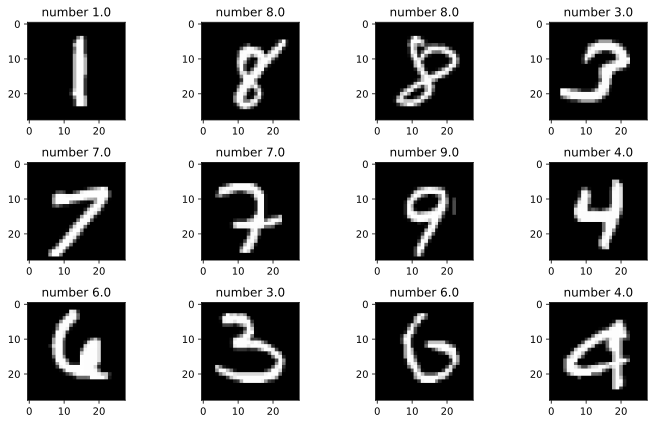

In [3]:
data=np.loadtxt(open('mnist_train_small.csv','rb'),delimiter=',')
label=data[:,0]
data=data[:,1:]

fig,axs=plt.subplots(3,4,figsize=(10,6))
for ax in axs.flatten():
    randimg=np.random.randint(0,data.shape[0])
    img=np.reshape(data[randimg,:],(28,28))
    ax.imshow(img,cmap='gray')
    
    ax.set_title(f"number {label[randimg]}")
    
plt.tight_layout()
plt.show()

In [4]:
dataNorm=data/np.max(data)

dataT=torch.tensor(dataNorm).float()
labelT=torch.tensor(label).float()
labelT=labelT[:,None]

print(labelT.shape)
print(dataT.shape)

torch.Size([20000, 1])
torch.Size([20000, 784])


# neural network

In [5]:
def createModel():
    class model(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input=nn.Linear(784,200)
            
            self.encoder=nn.Linear(200,15)
            
            self.latent=nn.Linear(15,200)
            
            self.decoder=nn.Linear(200,784)
            
        def forward(self,x):
            
            x=F.relu( self.input(x) )
            
            x=F.relu(self.encoder(x))
            x=F.relu(self.latent(x))
            
            x=torch.sigmoid(self.decoder(x))
            return x
    
    ann=model()
    
    lossfun=nn.MSELoss()
    
    optimizer=torch.optim.Adam(ann.parameters(),lr=0.001)
    
    return ann,lossfun,optimizer

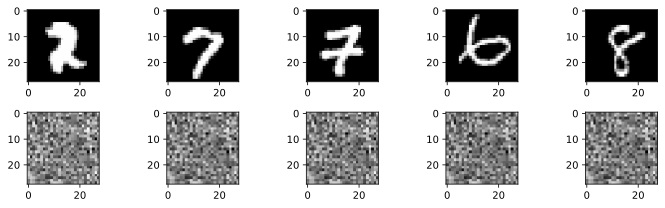

In [6]:
Ann=createModel()[0]
test=dataT[10:15,:]
yHat=Ann(test)

fig,ax=plt.subplots(2,5,figsize=(10,3))
for i in range(5):
    ax[0,i].imshow(test[i,:].view(28,28).detach(),cmap='gray')
    ax[1,i].imshow(yHat[i,:].view(28,28).detach(),cmap='gray')
    
plt.tight_layout()
plt.show()

# model train

In [7]:
def trainModel(numepoch=10000):
    ANN,lossfun,optimizer=createModel()
    
    losses=torch.zeros(numepoch)
    ANN.to(device)
    for epoch in range(numepoch):
        
        randomidx=np.random.choice(dataT.shape[0],size=32)
        dat=dataT[randomidx,:]
        dat=dat.to(device)
        
        yHat=ANN(dat)
        loss=lossfun(yHat,dat)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses[epoch]=loss.item()
    return ANN,losses

Text(0, 0.5, 'Model loss')

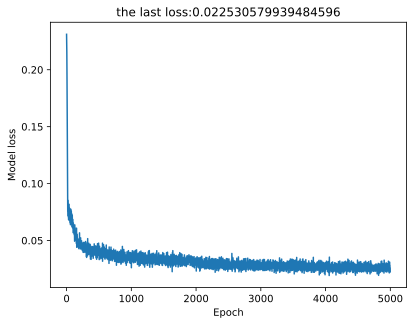

In [8]:
ANN,losses=trainModel(5000)
plt.plot(losses)
plt.title(f'the last loss:{losses[-1]}')
plt.xlabel('Epoch')
plt.ylabel('Model loss')

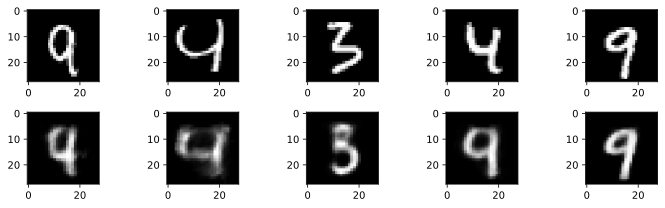

In [9]:
testdata=dataT[20:25,:]
testdata=testdata.to(device)
result=ANN(testdata)

result=result.cpu()
testdata=testdata.cpu()

fig,ax=plt.subplots(2,5,figsize=(10,3))

for i in range(5):
    ax[0,i].imshow(testdata[i,:].view(28,28).detach(),cmap='gray')
    ax[1,i].imshow(result[i,:].view(28,28).detach(),cmap='gray')
    
plt.tight_layout()
plt.show()

# network testing over noised images

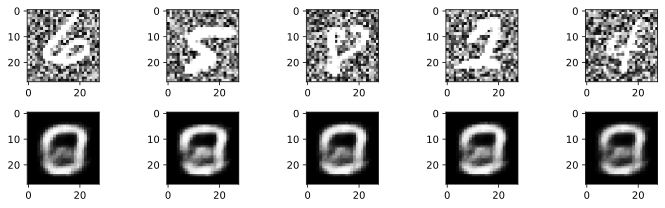

In [13]:
randomidx=np.random.randint(dataT.shape[0],size=5)
Img_thatnoise=dataT[randomidx,:]
noiseImg=Img_thatnoise+torch.rand_like(Img_thatnoise)/4
noiseImg[noiseImg>1]=1

noiseImg=noiseImg.to(device)
modelRes=ANN(noiseImg)

noiseImg=noiseImg.cpu()
modelRes=modelRes.cpu()

fig,ax=plt.subplots(2,5,figsize=(10,3))

for i in range(5):
    ax[0,i].imshow(noiseImg[i,:].view(28,28).detach(),cmap='gray')
    ax[1,i].imshow(modelRes[i,:].view(28,28).detach(),cmap='gray')
    
plt.tight_layout()
plt.show()